In [31]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
tf.keras.backend.set_floatx('float32')
# tf.config.threading.set_inter_op_parallelism_threads(1) #set cores for TF
# tf.config.threading.set_intra_op_parallelism_threads(1)
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
import numpy as np
import keras
import scipy
import matplotlib.pyplot as plt
from time import time
from keras.src.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split


In [32]:
def DataPreprocessing(data, ff):

    fmat = {0.1:data['sbsl_PINN'][0][0], 0.08:data['sbsl_PINN'][1][0], 0.06:data['sbsl_PINN'][2][0], 0.04:data['sbsl_PINN'][3][0], 0.02:data['sbsl_PINN'][4][0], 0.01:data['sbsl_PINN'][5][0], 0.005:data['sbsl_PINN'][6][0], 0.0:data['sbsl_PINN'][7][0]}
    fval = [0.1  , 0.08 , 0.06 , 0.04 , 0.02 , 0.01 , 0.005, 0.000]
    i = ff
    N = fmat[i].shape[1]
    U = np.zeros((N,4))
    U[:,0] = data['eta']
    U[:,1] = fmat[i][0,:]
    U[:,2] = fmat[i][1,:]
    U[:,3] = fmat[i][2,:]
    #U[:,4] = torch.from_numpy(np.array([0.06]))

    D = np.array(data['D'])
    M = np.array(data['M'])
    u = np.array(data['ubar'])
    dMdx = np.array(data['dMdx'])
    dudx = np.array(data['dudx'])
    alpha = np.array(data['alp'])
    eta1 = np.array(data['eta'])   

    meanflow = np.zeros((D.shape[1],7))
    meanflow[:,0] = D
    meanflow[:,1] = M
    meanflow[:,2] = u
    meanflow[:,3] = dMdx
    meanflow[:,4] = dudx
    meanflow[:,5] = alpha
    meanflow[:,6] = eta1
    #meanflow = torch.tile(meanflow, (8,1))

    he = np.array([0.00])
    HE = np.tile(he, (N,1)) 
    #He = HE.flatten()[:,None]

    uu = U[:, 1:4]
    uu0 = U[:,0]
    uu0 = uu0.flatten()[:, None]

    input_set = tf.concat([HE, uu0],1)

    return input_set, tf.convert_to_tensor(uu), tf.convert_to_tensor(meanflow)

## Train and Test Data Generation

In [33]:
data = scipy.io.loadmat('/Users/ramtarun/Desktop/Cambridge/Indirect-Noise-in-Nozzles/Data/Data_PINN_subsonic_geom_linvelsup_f0-0.1.mat')
# inp, targets, meanflow = DataPreprocessing(data, ff=0.01)
inp2, Y, meanflow2 = DataPreprocessing(data, ff=0.1)
X = tf.concat([inp2, meanflow2],1)
ftrain = [0.08 , 0.06 , 0.04 , 0.02]
fval = [0.00, 0.01, 0.005]
for i in ftrain:
    inp, targets, meanflow = DataPreprocessing(data, ff=i)
    x = tf.concat([inp, meanflow], axis=1)
    X = tf.concat([X, x], axis=0)
    Y = tf.concat([Y, targets], axis = 0)

print(X.shape, Y.shape)

inp, Y_test, meanflow = DataPreprocessing(data, ff=0.00)
X_test = tf.concat([inp, meanflow],1)
for i in fval[1:]:
    t1, t2, t3 = DataPreprocessing(data, ff=i)
    x = tf.concat([t1, t3], axis=1)
    X_test = tf.concat([X_test, x], axis=0)
    Y_test = tf.concat([Y_test, t2], axis = 0)


print(X_test.shape, Y_test.shape)

## Auxilary Function

In [38]:
def transform_sequence(tensor, seq_length):
    # tensor shape: (N, 2)
    # seq_length: desired sequence length

    N = tensor.shape[0]
    transformed_sequences = []

    for i in range(N - seq_length + 1):
        sequence = tensor[i : i + seq_length]
        transformed_sequences.append(sequence)

    transformed_tensor = tf.stack(transformed_sequences)

    # transformed_tensor shape: (N - seq_length + 1, seq_length, 2)
    return tf.cast(transformed_tensor, dtype=tf.float32)

def transform_original(tensor):
    new_tensor = tensor[:, 0, :]
    temp2 = tf.concat([new_tensor, tensor[-1][1:,:]], axis=0)
    return tf.cast(temp2, dtype=tf.float32)

def pde_residual(r_n, gr):
    return r_n + gr

def RHS_ff_t(y, baseflow, f):

    y = tf.cast(y, dtype=tf.float32)
    f = tf.cast(f, dtype=tf.float32)
    baseflow = tf.cast(baseflow, dtype=tf.float32)

    pi_p, pi_m, sig = tf.unstack(y,axis=1)

    D = baseflow[:,0]
    M = baseflow[:,1]
    u = baseflow[:,2]
    dMdx = baseflow[:,3]
    dudx = baseflow[:,4]
    alpha = baseflow[:,5]
    eta1 = baseflow[:,6]    
    
    He = 0
    # He = tf.constant(0.0, dtype=tf.float32) #a constant input

    gamma = 1.4#constant
    
    Msq = tf.math.square(M)

    Lambda = 1 + Msq * (gamma-1)/2
    zeta = f*gamma*Msq - 2*tf.math.tan(alpha)
    C1= ((gamma - 1)*(1-Msq)*f)/(2*Lambda*zeta)
    Ca = -C1*M*u*dMdx*(2-(2*Msq/(1-Msq)) - (2*gamma*Msq*(-2*f*Lambda - (gamma-1)/gamma *zeta)/(2*Lambda*zeta)))
    Ff = -(dudx + (4*f*u/(2*D)))

    denom = (M**2*u - u + C1*Msq *u + C1*Msq*Msq*gamma*u) #M**4
    vrh_p = M*(2*(1-M) + C1*M*(M-2+M*gamma*(1-2*M)))/(2*denom)
    vrh_m = -M*(2*(1+M) + C1*M*(M+2+M*gamma*(1+2*M)))/(2*denom)
    vkp_p = Msq*C1*(2+M*(gamma-1))/(2*denom)
    vkp_m = Msq*C1*(2-M*(gamma-1))/(2*denom)
    vth_p = C1*M*(M*(1+gamma) + M**2*(1-gamma) - 2)/denom
    vth_m = C1*M*(M*(1+gamma) - M**2*(1-gamma) + 2)/denom
    vsig = -(C1*Msq*(1+gamma*Msq) + Msq - 1)/denom
    calM = dMdx/(2*M)
    kp_p = (gamma - 1) + (2/M)
    kp_m = (gamma - 1) - (2/M)
    Gm_p = M*(Ca*(M + 1) + Ff*M*(C1*gamma*M*Msq + M + (1 - C1*Msq)))/(2*denom)
    Gm_m = M*(Ca*(M - 1) - Ff*M*(C1*gamma*M*Msq + M - (1 - C1*Msq)))/(2*denom)
    Ups = (Ca*(Msq - 1) - C1*Ff*Msq*Msq *(1+gamma))/denom
    
#     eq1 = - (2*np.pi*1j*He*vrh_p + Gm_m*kp_m + calM)*pi_p + (2*np.pi*1j*He*vkp_p + Gm_m*kp_p + calM)*pi_m - Gm_m*sig
#     eq2 = - (2*np.pi*1j*He*vkp_m + Gm_p*kp_m - calM)*pi_p - (2*np.pi*1j*He*vrh_m + Gm_p*kp_p + calM)*pi_m - Gm_m*sig
#     eq3 = - (2*np.pi*1j*He*vth_p + Ups*kp_m)*pi_p - (2*np.pi*1j*He*vth_m + Ups*kp_p)*pi_m - (2*np.pi*1j*He*vsig + Ups)*sig
    
#     eq1 = - tf.multiply((Gm_m*kp_m + calM),pi_p) + tf.multiply(( Gm_m*kp_p + calM),pi_m) - tf.multiply(Gm_m,sig)
    eq1 =  (Gm_m*kp_m + calM)*pi_p + ( Gm_m*kp_p - calM)*pi_m + Gm_m*sig
    eq2 =  ( Gm_p*kp_m - calM)*pi_p + ( Gm_p*kp_p + calM)*pi_m + Gm_m*sig
    eq3 =  ( Ups*kp_m)*pi_p + ( Ups*kp_p)*pi_m + (Ups)*sig
    

    rhs = tf.stack([-eq1, -eq2, -eq3],axis=1)

    return tf.cast(rhs, dtype='float64')

In [40]:
def init_model():

    ### Keras Functional API
    inputs = keras.Input(shape= (None, 9))
    # o1 = keras.layers.LSTM(16, activation='tanh', return_sequences=True)(inputs)
    # o1 = keras.layers.Dense(1, activation='sigmoid')(o1)


    o2 = keras.layers.Dense(200, activation='tanh')(inputs)
    o2 = keras.layers.Dense(200, activation='tanh')(o2)
    o2 = keras.layers.Dense(200, activation='tanh')(o2)
    o2 = keras.layers.Dense(200, activation='tanh')(o2)
    o2 = keras.layers.Dense(200, activation='tanh')(o2)
    o2 = keras.layers.Dense(200, activation='tanh')(o2)
    o2 = keras.layers.Dense(3, activation='sigmoid')(o2)
    
    model = keras.Model(inputs = inputs, outputs=o2)
    
    return model


In [41]:
model = init_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 9)]         0         
                                                                 
 dense_9 (Dense)             (None, None, 200)         2000      
                                                                 
 dense_10 (Dense)            (None, None, 200)         40200     
                                                                 
 dense_11 (Dense)            (None, None, 200)         40200     
                                                                 
 dense_12 (Dense)            (None, None, 200)         40200     
                                                                 
 dense_13 (Dense)            (None, None, 200)         40200     
                                                                 
 dense_14 (Dense)            (None, None, 200)         4020

In [42]:
optim = tf.keras.optimizers.legacy.Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.9,
    epsilon=1e-07)

In [45]:
model.compile(loss='mse', optimizer=optim)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.000001, patience=500, restore_best_weights=True)

In [46]:
hist = model.fit(X, Y, epochs = 5000, batch_size=16, validation_data=(X_test, Y_test), verbose=1, callbacks=early_stopping)

Epoch 1/5000
  1/313 [..............................] - ETA: 1:22 - loss: 4.2386e-04

2023-08-12 20:26:09.501782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 4.9445e-04

2023-08-12 20:26:12.036332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 9ms/step - loss: 4.9445e-04 - val_loss: 7.8847e-04
Epoch 2/5000
313/313 [==============================] - 3s 8ms/step - loss: 5.4410e-04 - val_loss: 3.9459e-04
Epoch 3/5000
313/313 [==============================] - 3s 9ms/step - loss: 4.8668e-04 - val_loss: 7.4989e-04
Epoch 4/5000
313/313 [==============================] - 3s 9ms/step - loss: 4.7019e-04 - val_loss: 4.3187e-04
Epoch 5/5000
313/313 [==============================] - 3s 9ms/step - loss: 4.7081e-04 - val_loss: 5.9660e-04
Epoch 6/5000
313/313 [==============================] - 3s 9ms/step - loss: 5.1779e-04 - val_loss: 8.1844e-04
Epoch 7/5000
313/313 [==============================] - 3s 9ms/step - loss: 4.7117e-04 - val_loss: 7.1484e-04
Epoch 8/5000
313/313 [==============================] - 3s 9ms/step - loss: 4.5851e-04 - val_loss: 4.0553e-04
Epoch 9/5000
313/313 [==============================] - 3s 9ms/step - loss: 4.7179e-04 - val_loss: 7.9602e-04
Epoch 10/5000
313/313 [

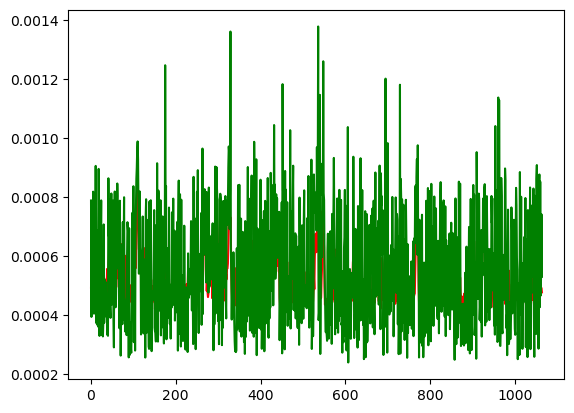

In [49]:
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'g')

32/32 [==============================] - 0s 3ms/step


2023-08-12 21:14:48.586384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


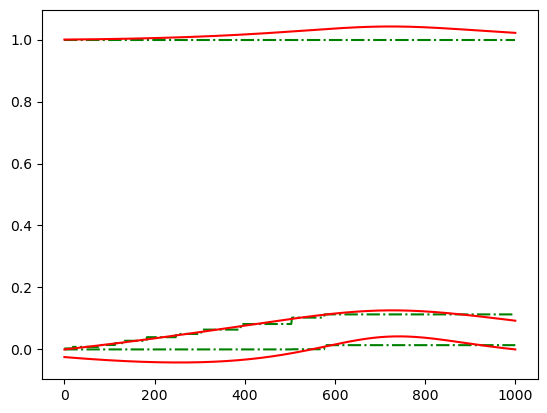

In [50]:
plt.plot((model.predict(X[:1001,:])), 'g-.')
plt.plot(Y[:1001,:], 'r')

## Physics Informed Model

In [80]:
LSTM_X = tf.concat([tf.reshape(X[2002:3003,1], (-1,1)), Y[2002:3003,:]], axis=1)
X_seq = transform_sequence(LSTM_X, 8)

In [81]:
inputs = keras.Input(shape=(None, 4))
outs = keras.layers.Dense(8, activation='tanh')(inputs)
outs = keras.layers.LSTM(64, activation='tanh', return_sequences=True, return_state=False)(outs)
outs = keras.layers.Dense(1, activation='sigmoid')(outs)
PINN = keras.Model(inputs=inputs, outputs = outs)
PINN.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 4)]         0         
                                                                 
 dense_20 (Dense)            (None, None, 8)           40        
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          18688     
                                                                 
 dense_21 (Dense)            (None, None, 1)           65        
                                                                 
Total params: 18793 (73.41 KB)
Trainable params: 18793 (73.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
def loss_func(X, model, f_pred):
    f_mean = tf.reduce_mean(f_pred)
    eta = tf.reshape(X[:,1], (-1,1))
    meanflow = X[:,2:]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        r = model(X)
        dr_dn = tf.reshape(tape.gradient(r, X)[:,1], (-1,1))
    
    residual = dr_dn + RHS_ff_t(r, meanflow, f_mean)

    del tape

    return tf.reduce_mean(tf.square(residual))

In [83]:
def loss_theta(pinn, model, X_seq, X): 
     with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(pinn.trainable_variables)
        f_pred = pinn(X_seq)
        f_pred = transform_original(f_pred)
        loss = loss_func(X, model, f_pred)

     grad = tape.gradient(loss, pinn.trainable_variables)
     del tape
     return loss, grad

In [84]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(X_seq, X, pinn, train = True):

    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = loss_theta(pinn, model, X_seq, X)
    
    if train:
        # Perform gradient descent step
        optim.apply_gradients(zip(grad_theta, pinn.trainable_variables))
    
    return loss

In [85]:
N = 2000
loss = np.zeros(N)
for epoch in range (N):
    train_loss = train_step(X_seq, X, PINN, train=True)
    loss[epoch] = train_loss
    print(f"Epoch {epoch + 1}/{N} - training_loss: {train_loss:.8f}")

2023-08-12 21:34:02.772316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-12 21:34:02.797808: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node zeros_like was passed float from model_5/lstm_3/PartitionedCall:6 incompatible with expected variant.
2023-08-12 21:34:02.865467: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node zeros_like was passed float from model_5/lstm_3/PartitionedCall:6 incompatible with expected variant.
2023-08-12 21:34:02.907009: W tensorflow/core/common_runtime/optimize_function_graph_utils.cc:573] Ignoring multi-device function optimization failure: INVALID_ARGUMENT: Input 0 of node zeros_like was passed float from model_5/lstm_3/PartitionedCall:6 incompatible with expected variant.
2023-08-12 21:34:03.010280: I tensorflow/core/grapple

Epoch 1/2000 - training_loss: 75961.96286963
Epoch 2/2000 - training_loss: 39778.69769020
Epoch 3/2000 - training_loss: 5268.43188164
Epoch 4/2000 - training_loss: 2837.01616084
Epoch 5/2000 - training_loss: 3415.10755773
Epoch 6/2000 - training_loss: 9498.45949247
Epoch 7/2000 - training_loss: 3599.14841594
Epoch 8/2000 - training_loss: 20298.72043649
Epoch 9/2000 - training_loss: 114657.02692043
Epoch 10/2000 - training_loss: 927595.42825565
Epoch 11/2000 - training_loss: 2957.77018195
Epoch 12/2000 - training_loss: 3885.92414080
Epoch 13/2000 - training_loss: 4352.48329551
Epoch 14/2000 - training_loss: 6870.79784611
Epoch 15/2000 - training_loss: 38910.79124634
Epoch 16/2000 - training_loss: 8380.07465807
Epoch 17/2000 - training_loss: 45814.78535619
Epoch 18/2000 - training_loss: 5643.26784312
Epoch 19/2000 - training_loss: 4974.00003721
Epoch 20/2000 - training_loss: 13283.58474222
Epoch 21/2000 - training_loss: 12759.03797674
Epoch 22/2000 - training_loss: 2960.86988848
Epoch 23

In [89]:
x1, x2, x3 = DataPreprocessing(data, ff=0.005)
x_seq = transform_sequence(tf.concat([tf.reshape(x1[:,1], (-1,1)),x2], axis = 1), 8)


In [90]:
f_pred = PINN(x_seq)
f_pred

<tf.Tensor: shape=(994, 8, 1), dtype=float32, numpy=
array([[[0.99706596],
        [0.9999963 ],
        [0.99999833],
        ...,
        [0.99999785],
        [0.99999785],
        [0.99999785]],

       [[0.9970758 ],
        [0.9999963 ],
        [0.99999833],
        ...,
        [0.99999785],
        [0.99999785],
        [0.99999785]],

       [[0.99708575],
        [0.9999964 ],
        [0.99999833],
        ...,
        [0.99999785],
        [0.99999785],
        [0.99999785]],

       ...,

       [[0.9995572 ],
        [0.999998  ],
        [0.99999845],
        ...,
        [0.99999785],
        [0.99999785],
        [0.99999785]],

       [[0.9995577 ],
        [0.999998  ],
        [0.99999845],
        ...,
        [0.99999785],
        [0.99999785],
        [0.99999785]],

       [[0.99955803],
        [0.999998  ],
        [0.99999845],
        ...,
        [0.99999785],
        [0.99999785],
        [0.99999785]]], dtype=float32)>

In [91]:
tf.reduce_mean(f_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9998629>